## **Modelo de batería de litio**
El siquiente código corresponde a un modelo de pack de baterías de litio.


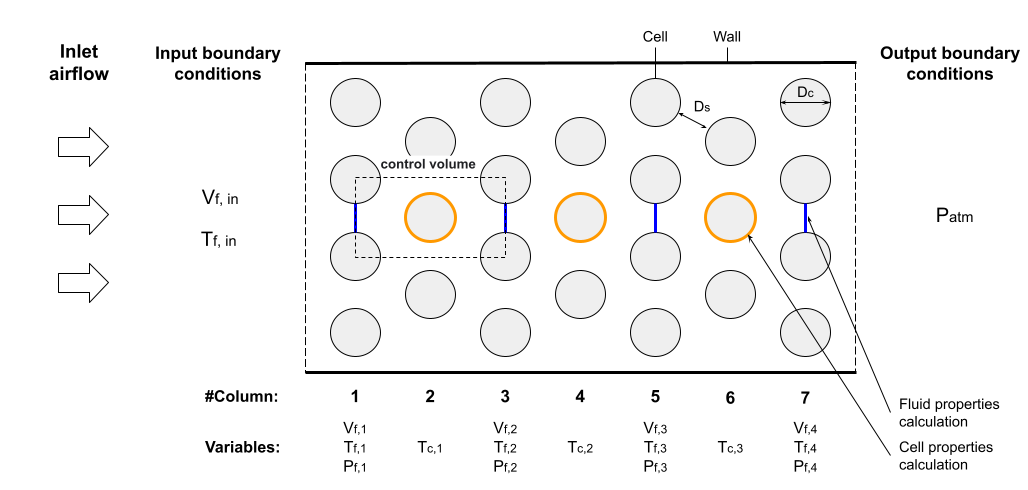

### Librerías

In [ ]:
import numpy as np
import pandas as pd
from scipy import interpolate

import warnings
warnings.filterwarnings('ignore')

## **Modelo**

In [ ]:
###############      Funciones de interpolación      #############

def interpolate1d(x2predict, xtrain, ytrain):
    f = interpolate.interp1d(xtrain, ytrain, fill_value='extrapolate')
    return f(x2predict)

def q_conductividad(_t):
    _t += 273.15
    _datos = np.array([22.3, 26.3, 30, 33.8, 37.3]) * 1e-3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _k = interpolate1d(_t, _temp, _datos)
    np.place(_k, _k < 0, 0.0001)
    np.place(_k, np.isnan(_k), 0.0001)
    return _k

def q_reynolds(_v, _t, _D, _d):
    _visc = q_viscosidad(_t)
    _re = _d * _v * _D / _visc
    return _re

def q_viscosidad(_t):
    _t += 273.15
    _datos = np.array([159.6, 184.6, 208.2, 230.1, 250.7]) * 1e-7
    _temp = np.array([250, 300, 350, 400, 450])
    _visc = interpolate1d(_t, _temp, _datos)
    np.place(_visc, np.isnan(_visc), 0)
    return _visc

def q_densidad(_t):
    _datos = np.array([1.293, 1.205, 1.127])
    _temp = np.array([0, 20, 40]) * 1.
    _d = interpolate1d(_t, _temp, _datos)
    np.place(_d, np.isnan(_d), 1.0)
    return _d

def q_cp(_t):
    _t += 273.15
    _datos = np.array([1.006, 1.007, 1.009, 1.014, 1.021]) * 1e3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _cp = interpolate1d(_t, _temp, _datos)
    np.place(_cp, np.isnan(_cp), 1.0)
    return _cp

###############       Ponderadores        ################

def f_v(S,D):
  return ((D--22.078451156303014)**0.13854518356399528*((S+-0.05273979112677948))**-0.4042472525258598)

def f_tf(I,Fo):
    output = (((34.861727563296036/Fo))**0.060547458674721236/(0.9882458698876305)**I)
    return output

def f_p(S,Fo):
  return (((34.861727563296036/S))**0.060547458674721236/(0.9882458698876305)**Fo)

def f_heat(S):
  return 0.713711013825012*(S**2)-2.37719740945025*S+3.82926914078176

class Model:
    def __init__(self, current=5, cellDiamater=26, separation=1, initFlow=100, \
                 initTemperature=26, col_fluido=2, col_celda=1, n_fluido=3, n_celda=0,\
                 nmax=50):
        """
		"""
        self.current = 1.0 * current                   # Corriente                   [A]
        self.cellDiameter = 1.0*cellDiamater           # Diametro Celda              [mm]
        self.separation = 1.0*separation               # Separacion                  [adimensional]
        self.initFlow = 1.0*initFlow                   # Flujo de entrada del fluido [CFM]
        self.initTemperature  = 1.0*initTemperature    # Temperatura incial          [Degree C]
        self.col_fluido = col_fluido
        self.col_celda = col_celda
        self.n_fluido = n_fluido
        self.n_celda = n_celda
        self.R = 32 * 1e-3      # Resistencia interna [Ohm]
        self.largo = 65 * 1e-3  # Largo celdas        [m]
        self.e = 15 * 1e-3      # espacio pared-celda [m]
        self.referencePressure = 0    # presion de referencia [Pa]
        self.errmax = 1e-3      # error corte
        self.nmax = nmax        # Iteraciones fluodinamicas

        self.sp = dict()        # Variables calculadas
        self.vars_vec = dict()
        self.err_vec = dict()

        self.cellDiameter_m = None
        self.initFlow_m3_sg = None
        self.individual = dict()


    def start(self):
        # ------------------------- Inputs Conversion --------------------------------
        self.cellDiameter_m = self.cellDiameter / 1000  # Diametro Celda              [mm]->[m]
        self.initFlow_m3_sg = self.initFlow * 0.00047   # Flujo de entrada del fluido [CFM]->[m3/s]

        # --------------------- Fixed parameters ------------------------------
        self.sp['piQuarter'] = np.pi / 4
        self.sp['doubleE'] = 2 * self.e
        self.sp['maxValue'] = np.finfo(np.float_).max

        # Medidas importantes
        self.sp['height'] = self.sp['doubleE'] + self.cellDiameter_m*(self.n_fluido + self.separation*self.n_celda)         # Altura del pack
        self.sp['sPlusOne'] = self.separation + 1
        self.sp['sTerm'] = self.separation / self.sp['sPlusOne']

        # Áreas
        self.sp['A_vol_in'] = self.separation * self.cellDiameter_m * self.largo     # Area de entrada al volumen de control
        self.sp['A_cell_sec'] = self.cellDiameter_m * self.largo                           # Area de sombra de una celda
        self.sp['A_battery_in'] = self.sp['height'] * self.largo                                # Area de entrada pack
        self.sp['A_cell_manto'] = np.pi * self.cellDiameter_m * self.largo                   # Area de la celda (manto)

        # /********************** Condiciones de borde *****************************************/
        v_in = self.initFlow_m3_sg/self.sp['A_battery_in']

        self.sp['initVelocity'] = f_v(self.separation,self.cellDiameter) * v_in
        self.sp['initTemperature'] = f_tf(self.current,self.initFlow) * self.initTemperature
        self.sp['lastPressure'] = f_p(self.separation,self.initFlow) + self.referencePressure

        # Cálculos de energía
        self.sp['qdot_cell'] = (self.current**2) * self.R                                             # Flujo de Calor total celda
        self.sp['qdot_vol'] = f_heat(self.separation) * self.sp['qdot_cell']                          # Flujo de Calor total volumen de control
        self.sp['heatPerArea'] = self.sp['qdot_cell'] / self.sp['A_cell_manto']
        self.sp['m_punto'] = self.sp['A_vol_in'] * self.sp['initVelocity'] * q_densidad(self.sp['initTemperature']) # Flujo masico [kg/s]
        self.sp['fluidTempTerm'] = self.sp['qdot_vol'] / self.sp['m_punto']

        # /********************** Initialization *****************************************/
        self.vars_vec['tf'] = self.sp['initTemperature'] * np.ones(self.col_fluido)      # [Degree C]
        self.vars_vec['pf'] = self.sp['lastPressure'] * np.ones(self.col_fluido)          # [Pa]
        self.vars_vec['vf'] = self.sp['initVelocity'] * np.ones(self.col_fluido)       # [m/s]
        self.vars_vec['vmf'] = self.sp['initVelocity'] * self.sp['sTerm'] * np.ones(self.col_fluido)      # [m/s]
        self.vars_vec['df'] = q_densidad(self.sp['initTemperature'])  * np.ones(self.col_fluido)                       # [kg/m3]
        self.vars_vec['tc'] = self.sp['initTemperature'] * np.ones(self.col_celda)       # [Degree C]
        self.vars_vec['ff'] = 0.0 * np.ones(self.col_fluido)                       # [N]
        self.vars_vec['rem'] = 1.0 * np.ones(self.col_celda)                       # [adimensional]
        self.vars_vec['prandtl'] = 0.0 * np.ones(self.col_celda)                       # [adimensional]

        self.vars_vec['cdrag'] = 0.0 * np.ones(self.col_celda)                      # [adimensional]
        self.vars_vec['frctionFactor'] = 0.0 * np.ones(self.col_celda)                        # [adimensional]
        self.vars_vec['nusselt'] = 0.0 * np.ones(self.col_celda)                        # [adimensional]

        self.vars_vec['fluidK'] = q_conductividad(self.vars_vec['tf'][0]) * np.ones(self.col_celda)  # [W/m k]

        # /********************** Errores en columnas ************************************/
        self.err_vec['cellTempError'] = self.sp['maxValue'] * np.ones(self.col_celda)
        self.err_vec['TFError'] = self.sp['maxValue'] * np.ones(self.col_fluido)
        self.err_vec['TFError'][0] = 0.0
        self.err_vec['velocityError'] = self.sp['maxValue'] * np.ones(self.col_fluido)
        self.err_vec['pressureError'] = self.sp['maxValue'] * np.ones(self.col_celda)

    def evolve(self):
        for _ in range(self.nmax):
            for i in range(self.col_celda):
                actualVF = self.vars_vec['vf'][i]
                actualVMF = self.sp['sTerm'] * actualVF
                self.vars_vec['vmf'][i] = actualVMF
                actualTF = self.vars_vec['tf'][i]
                nextTF = self.vars_vec['tf'][i]
                actualTMF = (actualTF+nextTF)/2
                actualDF = self.vars_vec['df'][i]
                i2 = i+1
                self.vars_vec['rem'][i] = q_reynolds(actualVMF, actualTMF, self.cellDiameter_m, actualDF)
                self.vars_vec['prandtl'][i] = q_viscosidad(actualTMF) * q_cp(actualTMF) / q_conductividad(actualTMF)
                actualRem = self.vars_vec['rem'][i]
                actualprandtl = self.vars_vec['prandtl'][i]

                # ***************************************** Calculo de la presion **************************************
                frictionFactor = self.individual['computeFrictionFactor'](actualRem, self.separation)
                self.vars_vec['frctionFactor'][i] = frictionFactor
                nextPF = self.vars_vec['pf'][i2]
                actualPF = nextPF + 0.5 * frictionFactor * actualDF * (actualVMF ** 2)
                self._setValue(self.vars_vec['pf'], i, self.err_vec['pressureError'], actualPF)

                # ***************************************** Calculo de la velocidad ************************************
                cdrag = self.individual['computeDragCoefficient'](actualRem, self.separation)
                self.vars_vec['cdrag'][i] = cdrag
                actualVFSquared = (actualVF ** 2)
                actualVMFSquared = (actualVMF ** 2)
                actualFF_cell = 0.5 * self.sp['A_cell_sec']  * actualDF * actualVMFSquared * cdrag
                actualFF_vol = 2*actualFF_cell
                self.vars_vec['ff'][i] = actualFF_vol
                nextVF = ((self.sp['A_vol_in'] * (actualPF - nextPF) - actualFF_vol) / self.sp['m_punto']) + actualVF
                nextVFSquared = (nextVF ** 2)
                self._setValue(self.vars_vec['vf'], i2, self.err_vec['velocityError'], nextVF)

                # ********************************** Calculo de la temperatura fluido **********************************
                nextTF = actualTF + (self.sp['fluidTempTerm'] - 0.5 * (nextVFSquared - actualVFSquared)) / q_cp(actualTF)
                self._setValue(self.vars_vec['tf'], i2, self.err_vec['TFError'], nextTF)

                # ***************************************** Calculo de la densidad *************************************
                self.vars_vec['df'][i2] = q_densidad(nextTF)

                # ********************************** Calculo de temperatura de celda ************************************
                actualTMF = (actualTF + nextTF) / 2
                nu = self.individual['computeNusseltNumber'](actualRem, actualprandtl, self.separation)
                self.vars_vec['nusselt'][i] = nu
                iniFluidK = q_conductividad(actualTF)
                self.vars_vec['fluidK'][i] = iniFluidK
                h = nu * iniFluidK / self.cellDiameter_m # [W m^-2 K^-1]
                self._setValue(self.vars_vec['tc'], i, self.err_vec['cellTempError'], self.sp['heatPerArea'] / h + actualTMF)

            # ********************************** If convergence, stop iterating ************************************
            flag1 = self.err_vec['cellTempError'].max() <= self.errmax
            flag2 = self.err_vec['TFError'].max() <= self.errmax
            flag3 = self.err_vec['pressureError'].max() <= self.errmax
            flag4 = self.err_vec['velocityError'].max() <= self.errmax
            flag12 = np.logical_and(flag1, flag2)
            flag34 = np.logical_and(flag3, flag4)
            if np.logical_and(flag12, flag34):
                break

        # ********************************** Guardar ************************************
        results_dict = {}
        results_dict['cdrag'] = self.vars_vec['cdrag']
        results_dict['frctionFactor'] = self.vars_vec['frctionFactor']
        results_dict['nusselt'] = self.vars_vec['nusselt']
        results_dict['vf'] = self.vars_vec['vf']
        results_dict['pf'] = self.vars_vec['pf']
        results_dict['tc'] = self.vars_vec['tc']
        results_dict['tf'] = self.vars_vec['tf']
        return results_dict

    def reset(self):
        self.__init__()

    def _setValue(self, vector, i, errorArray, value):
        errorArray[i] = vector[i]
        vector[i] = value
        errorArray[i] = np.abs((errorArray[i] - value) / value)

    def load_individual(self, cdrag_tree, ffriction_tree, nnusselt_tree):
        '''
        :param cdrag_tree:     inputs(5) (reynolds, separation, index, normalizedArea, normalizedDensity)
        :param ffriction_tree: inputs(5) (reynolds, separation, index, normalizedVelocity, normalizedDensity)
        :param nnusselt_tree:  inputs(4) (reynolds, prandtl, separation, index)
        '''
        self.individual['computeDragCoefficient'] = cdrag_tree
        self.individual['computeFrictionFactor']  = ffriction_tree
        self.individual['computeNusseltNumber']   = nnusselt_tree


def pow2(x):
    return x**2

## Probar modelo

A continuación se realizan los siguientes pasos:
 * Se crea un modelo entregandole parámetros
 * Se le entrega un individuo al modelo (Coeficiente de arrastre, Factor de fricción y Número de Nusselt)
 * Se modelan y grafican las distintas salidas del modelo (propiedades del fluido de refrigeración, propiedades de las celdas)

In [ ]:
### Individuos a valuar ###
# coeficiente de arrastre | factor de fricción | numero de nusselt
ind = [ lambda Rem, S: (2*(S))/((Rem**0.1)*(S+1)), \
        lambda Rem, S: (-(Rem)/6500-0.2+(4.4/S)), \
        lambda Rem, Prandtl, S: 0.08 * (S**-0.22) * (Rem**0.64) * (Prandtl**-4)]

### cálculo de celdas por columna ###
n_celdas = 53 # en el dataset se tienen baterías de 25, 53, 74, 102 celdas
col_fluido=int((n_celdas+3)/7)
col_celda=int(col_fluido-1)

In [ ]:
mdl = Model(current=10, cellDiamater=20, separation=1.0, initFlow=100, initTemperature=18, col_fluido=col_fluido, col_celda=col_celda, n_fluido=4, n_celda=3, nmax=10)
mdl.load_individual(*ind)
mdl.start()
results_dict = mdl.evolve()
V_array = results_dict['vf']
P_array = results_dict['pf']
T_array = results_dict['tf']
TC_array = results_dict['tc']

### Visualizar curvas
En la siguiente sección se visualizan las curvas para el modelamiento realizado. Las salidas del modelo corresponden a:
*   Valocidad de fluido
*   Presión de fluido
*   Temperatura de fluido
*   Temperatura de celda



In [ ]:
import matplotlib.pyplot as plt

columnas_de_fluido = list(range(1, (col_fluido)*2 +1, 2))
columnas_de_celda = list(range(2, (col_celda)*2 +1, 2))

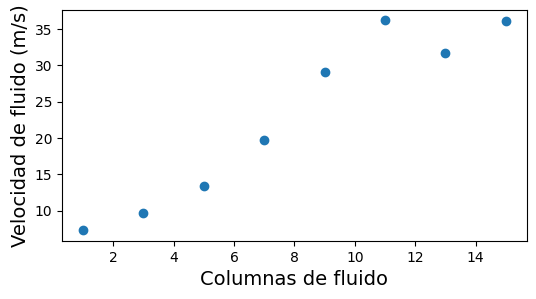

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.scatter(columnas_de_fluido, V_array)
ax.set_xlabel('Columnas de fluido',fontsize=14)
ax.set_ylabel('Velocidad de fluido (m/s)',fontsize=14)
plt.show()

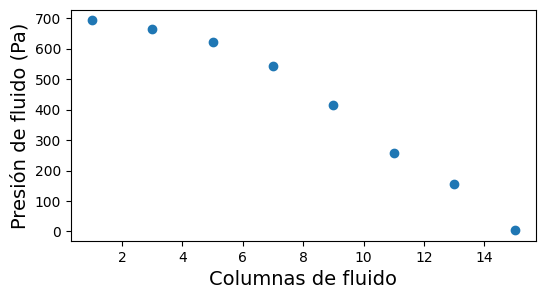

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.scatter(columnas_de_fluido, P_array)
ax.set_xlabel('Columnas de fluido',fontsize=14)
ax.set_ylabel('Presión de fluido (Pa)',fontsize=14)
plt.show()

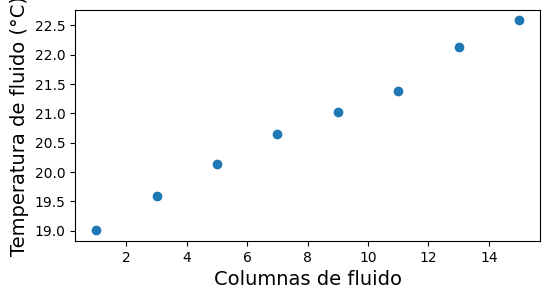

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.scatter(columnas_de_fluido, T_array)
ax.set_xlabel('Columnas de fluido',fontsize=14)
ax.set_ylabel('Temperatura de fluido (°C)',fontsize=14)
plt.show()

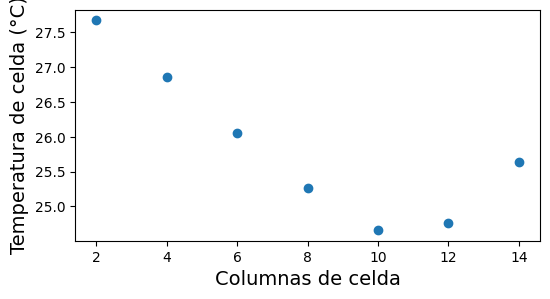

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.scatter(columnas_de_celda, TC_array)
ax.set_xlabel('Columnas de celda',fontsize=14)
ax.set_ylabel('Temperatura de celda (°C)',fontsize=14)
plt.show()